In [1]:

import plotly.graph_objects as go
from collections import defaultdict, Counter
import matplotlib.colors as mcolors

from sklearn.metrics import silhouette_samples, silhouette_score, accuracy_score, recall_score, precision_score
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans, MiniBatchKMeans, Birch
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import LogisticRegression as LR
from sklearn.linear_model import Ridge
from sklearn.preprocessing import normalize
from scipy.sparse import *
from sklearn.model_selection import train_test_split
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from gensim.models.word2vec import Word2Vec


import matplotlib.cm as cm

from itertools import permutations, cycle, islice
import os
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from interpret import show
from interpret.perf import ROC
from interpret.glassbox import ExplainableBoostingClassifier, LogisticRegression, ClassificationTree, DecisionListClassifier
from interpret.blackbox import ShapKernel
from interpret.data import ClassHistogram

from xgboost import XGBClassifier
import shap




In [1]:
from data_loader import *
from utils import smart_inverse, decompose

from sklearn.preprocessing import normalize
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from gensim.models.word2vec import Word2Vec
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt# Noise block
import numpy as np
sns.set()
%matplotlib inline

In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
%%time
Dataset()
Users()
CityStats()

Loading pickled data
5197222 transactions loaded
Filtering users: 51143 out of 165579 remain. Percentage of transactions covered: 81.31
Wall time: 2min 13s


In [14]:
%%time
if os.path.exists(EMBEDDING_PATH):
    with open(EMBEDDING_PATH, 'rb') as f:
        embeddings_dict = pickle.load(f)
else:
    dataset = [Transaction.to_sentence(t) for t in Dataset().transactions]
    print('created_dataset')
    gensim_skipgram = Word2Vec(dataset, window=100, min_count=1, workers=12,sg=1,iter=4, min_alpha=0.0001,sample=1e-4)
    with open(EMBEDDING_PATH, 'wb') as f:
        pickle.dump(gensim_skipgram.wv, f)
    embeddings_dict = gensim_skipgram.wv


created_dataset
Wall time: 18min 48s


(40, 2) 40


C:\ProgramData\Anaconda2\envs\strauss\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


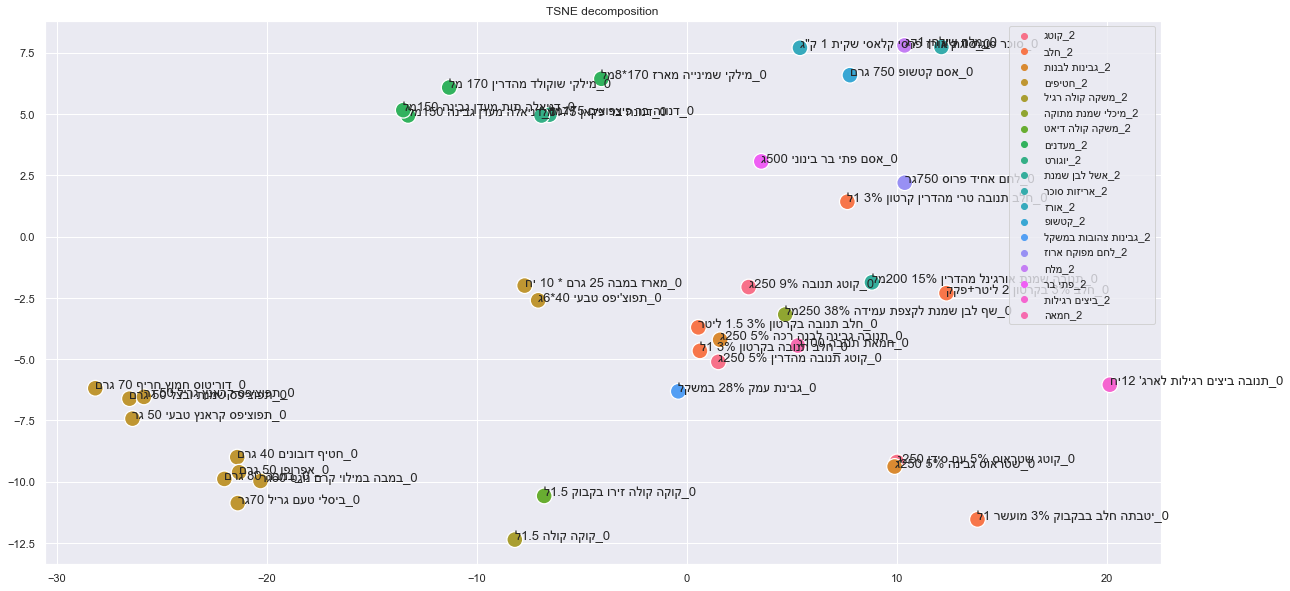

In [20]:
products = sorted(Dataset().products, key=lambda x: x.usages, reverse=True)[:300]
product_vectors = np.vstack([embeddings_dict[x.barcode] for x in products])
decompose(product_vectors, tsne=True, show=40, hue=[smart_inverse(x.hierarchy_names[2]) for x in products[:40]], annotations=[smart_inverse(x.name) for x in products[:40]])

In [21]:
stats_df = pd.DataFrame(CityStats().stats_df)
stats_df = stats_df[stats_df.n_users > 30]
city_embeddings = np.vstack([embeddings_dict[x] for x in stats_df.index.values])
city_embeddings_normalized = normalize(city_embeddings, axis=1)

socio R squared 0.5754085949489436 MAE 0.5470615155405498
diabetes_ratio R squared 0.43163873018391796 MAE 7.238569932901271
haredim R squared 0.47807507815773614 MAE 15.457305303888202


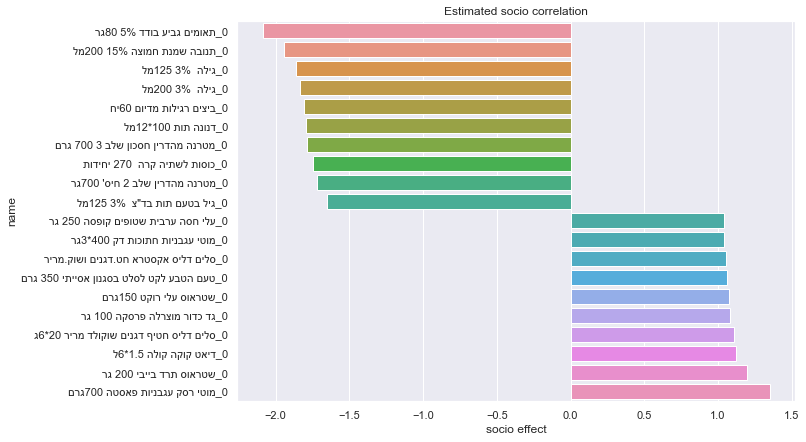

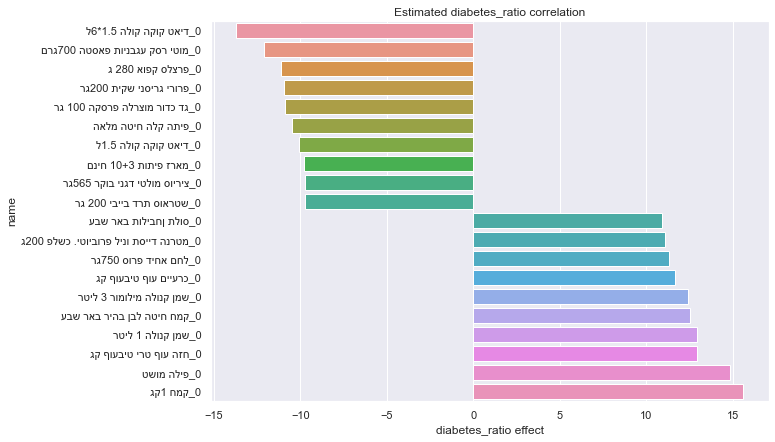

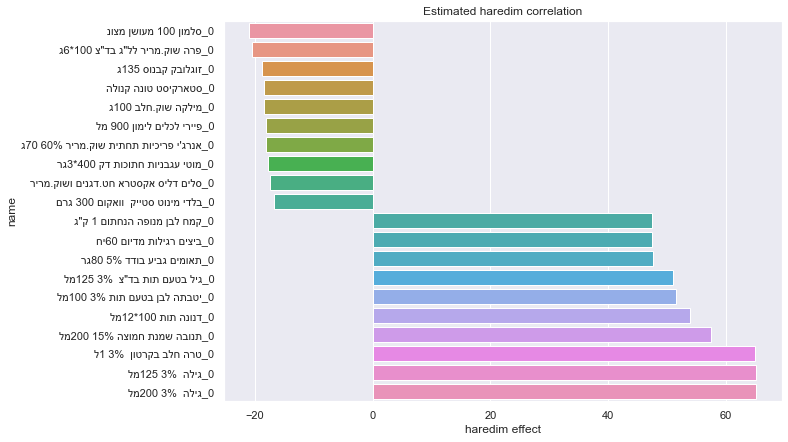

In [23]:
model = Ridge(alpha=5)
for column in ['socio', 'diabetes_ratio', 'haredim']:
    model.fit(city_embeddings_normalized, stats_df[column].values)
    top_products = [x.barcode for x in Dataset().products if x.usages > 10000]
    column_name = column+' effect'
    socio_df = pd.DataFrame(data=[[Dataset().barcode_to_product[x].name, x, model.predict(embeddings_dict[x].reshape(1, -1))[0] - model.intercept_] for x in top_products], columns=['item', 'barcode', column_name])
    
    socio_df['name'] = socio_df.item.map(smart_inverse)
    socio_df = socio_df.sort_values(column_name)
    f = plt.figure(figsize=(10,7))
    p = sns.barplot(y='name', x=column_name, data=socio_df.head(10).append(socio_df.tail(10)))
    p.set_title('Estimated ' + column +' correlation')
    print(column, 'R squared',model.score(city_embeddings_normalized, stats_df[column].values), 'MAE',   mean_squared_error(model.predict(city_embeddings_normalized), stats_df[column].values, squared=False))

In [ ]:
decompose(city_embeddings, tsne=True, hue=stats_df.socio, annotations=[smart_inverse(x) for x in stats_df.index.values])
decompose(city_embeddings, tsne=True, hue=stats_df.haredim, annotations=[smart_inverse(x) for x in stats_df.index.values])

(82, 2) 82


C:\ProgramData\Anaconda2\envs\strauss\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


In [ ]:
user_embeddings = np.vstack([embeddings_dict[x] for x in Users().active_users])
user_embeddings_normalized = normalize(user_embeddings, axis=1)

In [127]:
model.fit(city_vectors, city_df.loc[used_cities]['socio'].values)
user_socio = model.predict(user_embeddings)

model.fit(city_vectors, city_df.loc[used_cities]['diabetes_ratio'].values)
user_diabetes = model.predict(user_embeddings)
user_diabetes = (user_diabetes- user_diabetes.mean())/np.std(user_diabetes)

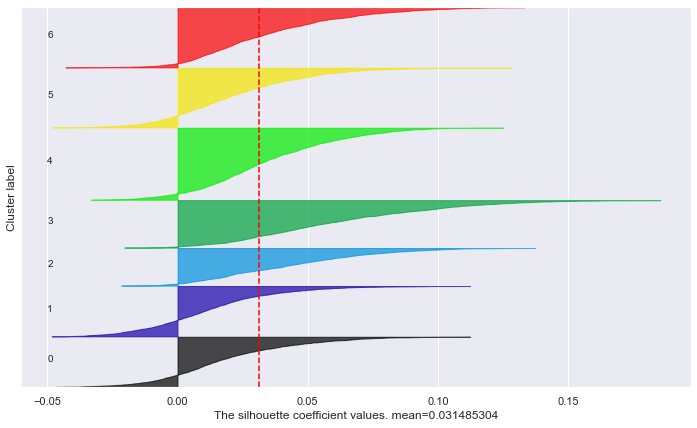

In [299]:
def viz_silhoette(X, cluster_labels, title='', ax=None):
    if X.shape[0] > 10000:
        idx = np.random.choice(X.shape[0], size=10000, replace=False)
        X = X[idx]
        cluster_labels = cluster_labels[idx]
    
    n_clusters = len(set(cluster_labels))
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    
    if ax is None:
        f, ax1 = plt.subplots(1,1, figsize=(12,7))
    else:
        ax1 = ax
    ax1.set_ylim([0, X.shape[0] + (n_clusters + 1) * 10])
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title(title)
    ax1.set_xlabel("The silhouette coefficient values. mean=" +str(np.mean(sample_silhouette_values)))
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=np.mean(sample_silhouette_values), color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    
    if ax is None:
        plt.show()


clf = MiniBatchKMeans(n_clusters=7, random_state=2)
#clf = GaussianMixture(n_components=5, random_state=3)
user_clusters = clf.fit_predict(user_embeddings)
viz_silhoette(X, user_clusters)

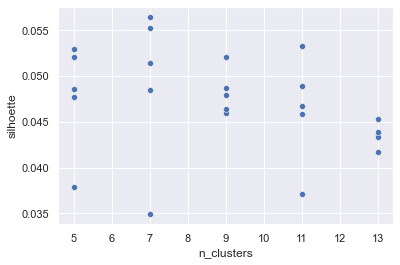

In [44]:
res = []
for k in range(5,15,2):
    for restart in range(5):
        clf = MiniBatchKMeans(n_clusters=k, random_state=restart)
    #clf = GaussianMixture(n_components=10, random_state=3)
        y = clf.fit_predict(user_embeddings)
        res.append([k, silhouette_score(user_embeddings, y)])
sns.scatterplot(x='n_clusters', y='silhoette', data=pd.DataFrame(data=res, columns=['n_clusters', 'silhoette']))

In [ ]:
LOAD_VECS = True
if LOAD_VECS:
    with open(clustering_path, 'rb') as f:
        user_vectors = pickle.load(f)
else:
    user_vectors = {u: np.zeros(sum(LEVEL_SIZE[:-1])) for u in {x.user_id for x in transactions}}
    for t in transactions:
        if t.user_id not in user_vectors.keys():
            continue
        for barcode in t.barcodes:
            p = barcode_to_product[barcode]
            user_vectors[t.user_id][p.hierarchy_indices[:min(p._representation+1, 4)]] += 1
    with open(clustering_path, 'wb') as f:
        pickle.dump(user_vectors, f)

tf_matrix = np.vstack([user_vectors[x] for x in filtered_users])  
tf_normalized = normalize(tf_matrix, axis=1, norm='l1')

del user_vectors

In [301]:
offset = sum(LEVEL_SIZE[:-2])
feature_names = [x[2:].replace('[', '(').replace(']', ')').replace('<', ' ') for x in list(INDEX_OF.keys())[offset:tf_normalized.shape[1]]]
df = pd.DataFrame(data=normalize(tf_normalized[:, offset:], axis=1), columns=feature_names)
#

from sklearn.utils import resample
def split(cluster, np_array=False):
    X_train, X_test, y_train, y_test = train_test_split(df, [z==cluster for z in y], test_size=0.20, random_state=1)
    if X_train.shape[0] > sum(y_train)*3:
        z_df = X_train[[not x for x in y_train]]
        z_df = resample(z_df, n_samples=sum(y_train)*3, random_state=1)
        X_train = X_train[y_train].append(z_df)
        y_train = np.array([1]*(len(X_train) - len(z_df)) +[0]*len(z_df))
    # for the tests
    #X_train, _, y_train, _ = train_test_split(X_train, y_train, test_size=0.8, random_state=1)
    if np_array:
        return X_train.values, X_test.values, y_train, y_test
    return X_train, X_test, y_train, y_test

def viz_explanation(cluster=0):
    X_train, X_test, y_train, y_test = split(cluster)
    hist = ClassHistogram().explain_data(X_train, y_train, name = 'Train Data')

    ebm = ExplainableBoostingClassifier(random_state=1, n_jobs=8, interactions=0, max_bins=30)
    ebm.fit(X_train, y_train)   #Works on dataframes and numpy arrays
    ebm_global = ebm.explain_global(name='EBM')
    ebm_local = ebm.explain_local(X_test[y_test][:5].append(X_test[y_test].mean(), ignore_index=True), [1]*6, name='EBM') #first 5 positive instances and cluster center as 6th one
    ebm_perf = ROC(ebm.predict_proba).explain_perf(X_test, y_test, name='EBM')
    lr = LogisticRegression(random_state=1, feature_names=feature_names, penalty='l1', solver='liblinear', C=1)
    lr.fit(X_train, y_train)
    #sorted(zip(lr.sk_model_.coef_[0], feature_names), key=lambda x: x[0], reverse=True)[:10]
    lr_perf = ROC(lr.predict_proba).explain_perf(X_test, y_test, name='Logistic Regression')

    lr_global = lr.explain_global(name='Logistic Regression')
    lr_local = lr.explain_local(X_test[y_test][:5].append(X_test[y_test].mean(), ignore_index=True), [1]*6, name='LR local' )
    
    show([hist, lr_global, lr_perf, ebm_global, ebm_perf, ebm_local, lr_local], share_tables=True)

def viz_shap(cluster=0):
    X_train, X_test, y_train, y_test = split(cluster, True)
    model = XGBClassifier(use_label_encoder=False) 
    #model = sklearn.linear_model.LogisticRegression(max_iter=100, penalty='l1', solver='liblinear')
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    print(cluster, accuracy_score(y_test, predictions), recall_score(y_test, predictions))
    X_train = pd.DataFrame(X_train)
    X_train.columns = [x[::-1] for x in feature_names] if DATASET == 'strauss' else feature_names
    explainer = shap.Explainer(model, X_train)
    shap.initjs()
    shap_values = explainer(X_train)
    shap.summary_plot(shap_values, X_train)
    
def viz_lr(cluster=0, viz_center=False, k=20, positive=15):
    X_train, X_test, y_train, y_test = split(cluster, True)
    model = LR(max_iter=100, penalty='l1', solver='liblinear')
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    print(accuracy_score(y_test, predictions), recall_score(y_test,predictions), precision_score(y_test, predictions))
    if viz_center:
        weights = X_train[y_train].mean(axis=0)*model.coef_[0]
    else:
        weights = model.coef_[0]
    named_coef = list(zip(weights, feature_names))
    tmp = pd.DataFrame(sorted(named_coef, key=lambda x: x[0], reverse=True), columns=['Logistic regression weight', 'sub-category'])
    return tmp.head(positive).append(tmp.tail(k-positive))

def viz_lr_mixed(cluster=0, k=20, positive=15):
    X_train, X_test, y_train, y_test = split(cluster, True)
    model = LR(max_iter=100, penalty='l1', solver='liblinear', class_weight='balanced')
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    print(accuracy_score(y_test, predictions), recall_score(y_test,predictions), precision_score(y_test, predictions))
    X_train = df.values
    y_train = np.array([z==cluster for z in y])
    positive_weights = X_train[y_train].mean(axis=0)*model.coef_[0]
    negative_weights = X_train[~y_train].mean(axis=0)*model.coef_[0]
    tmp = pd.DataFrame(sorted(list(zip(positive_weights, feature_names)), key=lambda x: x[0], reverse=True)[:positive], columns=['Logistic regression weight', 'sub-category'])
    tmp2 = pd.DataFrame(sorted(list(zip(negative_weights, feature_names)), key=lambda x: x[0], reverse=True)[-(k-positive):], columns=['Logistic regression weight', 'sub-category'])
    tmp = tmp.append(tmp2)
    tmp['sub-category'] = tmp['sub-category'].map(smart_inverse)
    f = plt.figure(figsize=(10,7))
    p = sns.barplot(y='sub-category', x='Logistic regression weight', data=tmp)
    
    socio = user_socio[y_train].mean()
    dia = user_diabetes[y_train].mean()
    p.set_title('Cluster {} with {:.1f}% of users. Socio status: {:.2f}. Diabetes ratio (normalized): {:.2f}'.format(cluster, sum(y_train)/len(df)*100, round(socio, 2), round(dia, 2)))
    plt.savefig(str(cluster)+'.png')
    

def create_lists(cluster=0):
    X_train, X_test, y_train, y_test = split(cluster)
    cluster_center = X_train.iloc[y_train].mean(axis=0)
    
    #ebm = ExplainableBoostingClassifier(random_state=1, n_jobs=8, interactions=0, max_bins=30)
    #ebm.fit(X_train, y_train)
    #ebm_list = []
    
    model = XGBClassifier(use_label_encoder=False) 
    model.fit(X_train, y_train)
    explainer = shap.TreeExplainer(model, X_train)
    shap_values = explainer(X_train.append(cluster_center, ignore_index=True))
    shap_aggregated = shap_values[:-1,:][y_train,:].mean(axis=0).values
    
    shap_center = shap_values[-1,:]
    
    lr = LR(max_iter=100, penalty='l1', solver='liblinear')
    lr.fit(X_train, y_train)
    lr_prediction = X_train.values[y_train].mean(axis=0)*lr.coef_[0]
    lr_weights = lr.coef_[0]
    
    return shap_aggregated, shap_center.values, lr_prediction, lr_weights

In [302]:
def rank_to_score(rank, l):
    return len(l)-rank-1

def aggregate_lists(lists, method='rank'):
    if method == 'score':
        stacked_scores = np.stack(lists).T
        norm_scores = sklearn.preprocessing.StandardScaler().fit_transform(stacked_scores)
        new_scores = norm_scores.mean(1)
        return new_scores
    
    scores = np.zeros(len(lists[0]))
    for l in lists:
        list_scores = Counter(np.abs(l))
        less_than = {sc: sum([v for k,v in list_scores.items() if k < sc ]) for sc in list_scores.keys()}
        for i, v in enumerate(np.abs(l)):
            scores[i] += less_than[v]
            
    for i in range(len(lists[0])):
        if all(l[i] >= 0 for l in lists):
            continue
        elif all(l[i] <= 0 for l in lists):
            scores[i] = -scores[i]
        else:
            scores[i]=0
    return scores

def top_k_features(scores, k=20, positive=15):
    best = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)
    best = [(feature_names[i], scores[i]) for i in best]
    return best[:positive] + best[-(k-positive):]


0.8636638087187538 0.8866071428571428 0.49774436090225566
0.8028015940103852 0.8295557570262919 0.3877118644067797
0.8756188866078976 0.8352803738317757 0.44576059850374067
0.9073783359497645 0.9016881827209533 0.5761421319796954
0.8524332810047096 0.8950097213220998 0.5657517410897174
0.8466368796039125 0.8752783964365256 0.5168785620341956
0.8887815481222074 0.9187739463601533 0.5953326713008937


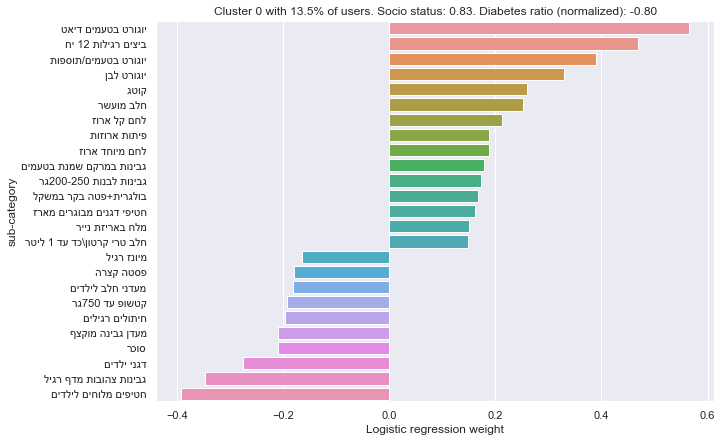

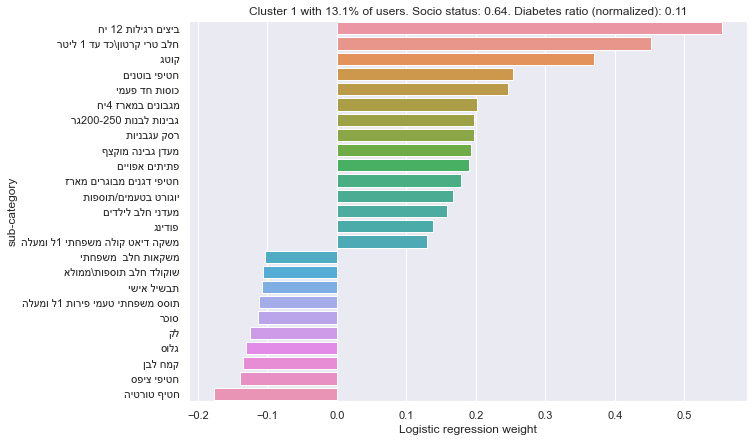

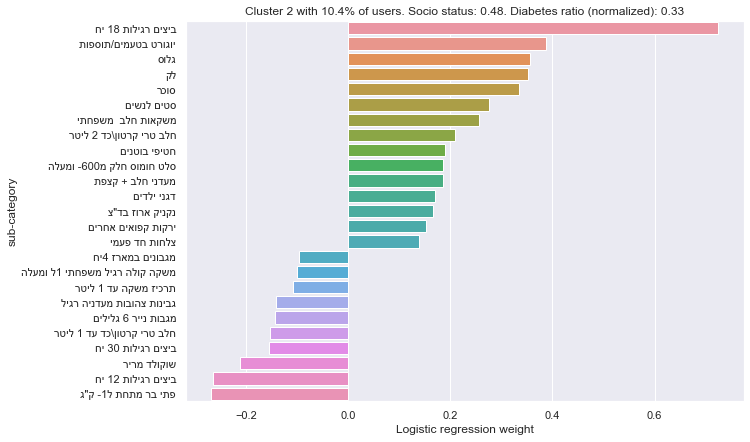

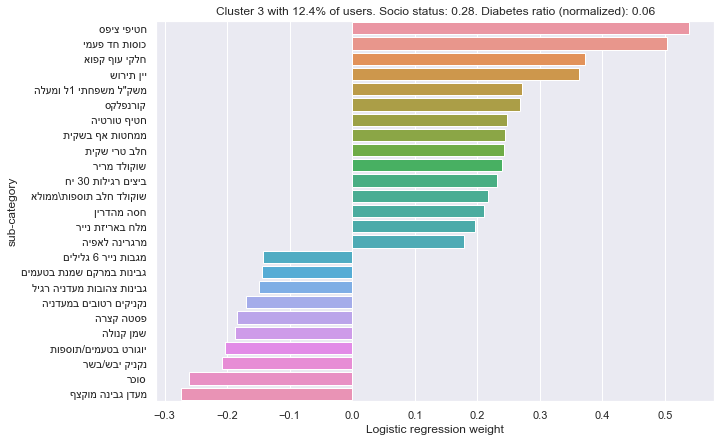

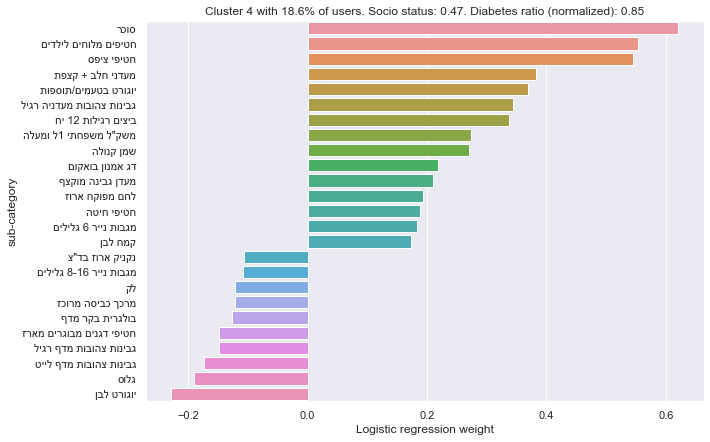

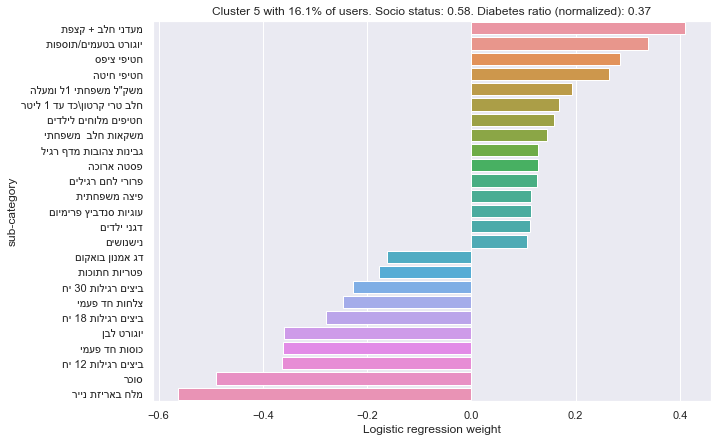

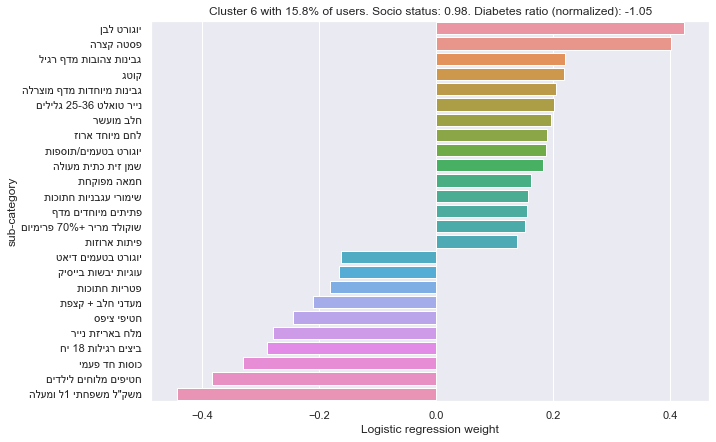

In [303]:
for i in range(7):
    viz_lr_mixed(i, 25, 15)

In [82]:
viz_explanation(5)
#viz_explanation(1)
#viz_explanation(2)
#viz_explanation(3)

<!-- http://127.0.0.1:7001/1051234356360/ -->
 Open in new window

[23:53:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
5 0.9488437942425673 0.8442565186751233


 99%|===================| 21566/21732 [01:46<00:00]        

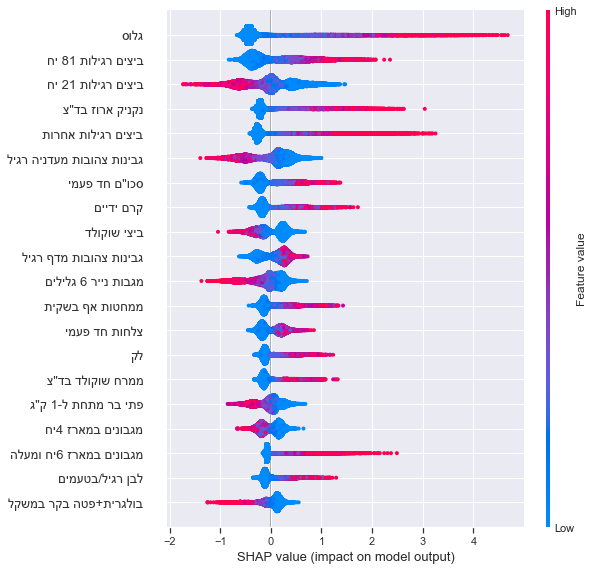

In [87]:
viz_shap(5)
#viz_shap(1)
#viz_shap(2)

In [89]:
viz_lr(5,True,20,20)

0.9492213308164228 0.8167723749119098 0.8065414057063326


,Logistic regression weight,sub-category
0,4.484060,גלוס
1,0.899561,סטים לנשים
2,0.803746,"סכו""ם חד פעמי"
3,0.644963,לק
4,0.582988,צלחות חד פעמי
5,0.426905,גבינות צהובות מדף רגיל
6,0.397114,חטיפי ציפס
7,0.396785,מגבות נייר 8-16 גלילים
8,0.395497,קרם ידיים
9,0.382220,"נקניק ארוז בד""צ"


In [10]:
h_usages = [defaultdict(int),defaultdict(int),defaultdict(int),defaultdict(int)]
for p in products:
    for i,h_name in enumerate(p.hierarchy_names[:-1]):
        h_usages[i][h_name[2:]] += p.usages
r = []
for d in h_usages:
    s = sum(d.values())
    d = {k: v/s for k,v in d.items()}
    r.append(d)
h_usages = r

In [11]:
sorted(h_usages[3].items(), key=lambda x: x[1], reverse=True)[:20]

[('יוגורט בטעמים/תוספות', 0.02340869077972964),
 ('קוטג 5%', 0.01796458925436599),
 ('חטיפי ציפס', 0.017473819945561478),
 ('מעדני חלב + קצפת', 0.015612073469826876),
 ('חלב טרי קרטון\\כד עד 1 ליטר', 0.01524069681184501),
 ('חטיפים מלוחים לילדים', 0.013097403530699768),
 ('חטיפי בוטנים', 0.01302348694298873),
 ('משק"ל משפחתי 1ל ומעלה', 0.012400720986962365),
 ('גבינות לבנות 200-250גר', 0.012205474147764572),
 ('חטיפי חיטה', 0.01061635384071971),
 ('יוגורט לבן', 0.010223606022937662),
 ('חלב מועשר', 0.008829473568863211),
 ('ביצים רגילות 12 יח', 0.007855426367683245),
 ('חטיף טורטיה', 0.007674769085961251),
 ('חלב טרי קרטון\\כד 2 ליטר', 0.007601773338169789),
 ('פסטה קצרה', 0.007473210656481359),
 ('שמנת חמוצה\\בטעמים', 0.007470102821752787),
 ('דגני ילדים', 0.007290519853270298),
 ('שמנת מתוקה', 0.006852315156541635),
 ('מעדן גבינה מוקצף', 0.006796920880129587)]

In [298]:
X = normalize(np.vstack([embeddings_dict[x] for x in top_products]), axis=1)
top_products = np.array(top_products)
similarity_matrix = np.dot(X, X.T)


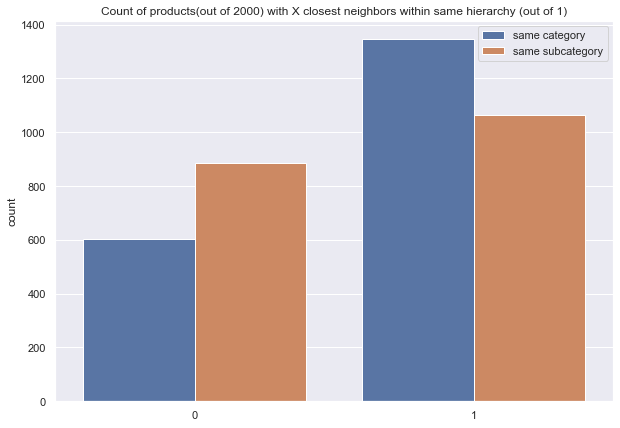

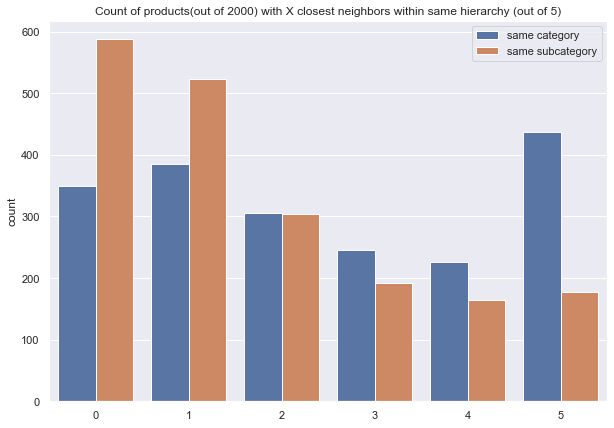

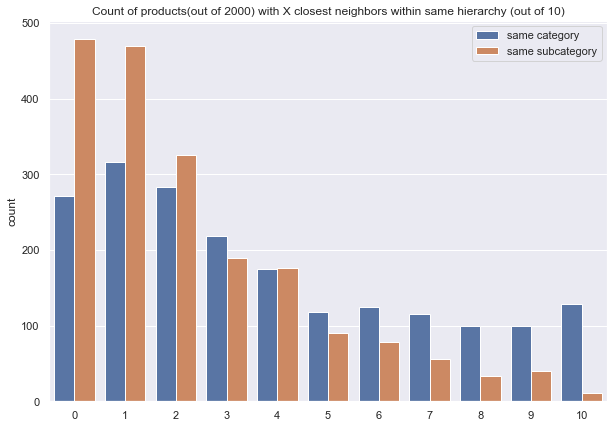

In [329]:
for k in [1,5,10]:
    same_subcat = []
    same_cat = []
    for i,row in enumerate(similarity_matrix):
        nn = top_products[row.argsort()[-k-1:][::-1]]
        same_cat.append(sum([barcode_to_product[x].hierarchy_names[-3] == barcode_to_product[top_products[i]].hierarchy_names[-3] for x in nn])-1)
        same_subcat.append(sum([barcode_to_product[x].hierarchy_names[-2] == barcode_to_product[top_products[i]].hierarchy_names[-2] for x in nn])-1)
    plt.figure(figsize=(10,7))
    p = sns.countplot(x=same_cat+same_subcat, hue=['same category']*len(same_cat) + ['same subcategory']*len(same_cat))
    p.set_title('Count of products with X closest neighbors within same hierarchy (out of {})'.format(k))
    #sns.countplot(x=same_subcat)